[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryangitsit/recurrent-mgd/blob/main/tutorials/mgd_intro_jax.ipynb)


*Only uncomment and run the following cell when working in colab or if repo not yet installed*

In [14]:
# !git clone https://github.com/ryangitsit/recurrent-mgd
# %cd recurrent-mgd
# !pip install -e .

# Introduction to Multiplexed Gradient Descent (MGD)
In an era of emerging specialized neuromorphic hardware, the demand for backprop-free gradient descent is more than ever. MGD is a perturbative method that offers a simple and efficient path to training arbitrary networks with respect to an objective function, so long as a gradient exists.  This notebook is a minimal example toward a practical understanding of MGD. 

### Some notes on using JAX (easily)
 - We utilize the JAX python package for flexible and efficient neural network operations
 - Wherever the jax.tree.map function is used, some operation is simply being mapped over a dictionary of parameters.
 - Wherever the @jax.jit decorator is used, the function that follows will be subject to "just in time" compilation
 - This can simply be thought of as preparing (compiling) the function to be used efficiently
 - JAX requires explicit seed (random key) definitions.  Where ever a key is defined, simply think of that as a seed.
 - Save for the final training example, we avoid obfuscating our implementation with calls to pacakages like jax.flax, which are even more efficent, but opaque

## Setup

In [2]:
import jax
import optax

import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt

import src.utils.helper_functions as hf
import src.data_loader as dat

#### CPU vs GPU
- If your local machine has a GPU available, the following should print something along the lines of `[CudaDevice(id=0)]` and otherwise a CPU device.  If your GPU is not showing, try running `pip install jax[cuda12]` depending on your cuda version (or uncomment and run the included jupyter command).  Note, a GPU is not necessary for this tutorial.

In [3]:
# !pip install jax[cuda12]
from jax import config
config.update("jax_default_matmul_precision", "float32")
print(jax.devices())

[CpuDevice(id=0)]


#### Loading Image Data
- Here we load the MNSIT handwritten-digit image classification set in memory.
- The details are related to simulation speed, not MGD, so just think of this as something that will feed your model data.

In [4]:
batch_size = 128
trainloader, testloader = dat.load_mnist_in_memory(batch_size)

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

#### Initialize (any) network
 - MGD is model-free and therefore indifferent to network topology, activation function, and node variation. 
 - We here implement a simple multi-layer feedforward neural network (an MLP).
 - In the recurrent tutorial, we examine more varied topologies.
 - The below network"
    - A feedforward artifical neural nework (ANN or MLP)
    - Relu activation funcitons in the hidden layers
    - Layer sizes defined by `hidden_dims`
    - Parameters given by `params` (produced under the hood by jax.flax.nn)
    - Forward pass function given by `__call__`
    - Note that parameters are only initialized with the first `model.init` call and then are otherwise run in a feedforward fashion given some input `x`

In [5]:
class MLP(nn.Module):
    hidden_sizes: list[int]
    @nn.compact
    def __call__(self, x):
        x = x.reshape(x.shape[0], -1)
        for size in self.hidden_sizes[:-1]:
            x = nn.relu(nn.Dense(size)(x))
        x = nn.Dense(self.hidden_sizes[-1])(x)
        return x
    
x_batch , y_batch = next(trainloader)
layer_dims        = [128,128,10]

model = MLP(hidden_sizes=layer_dims)

key    = jax.random.PRNGKey(0)
params = model.init(key, x_batch)['params']
print("Initialized network parameters:\n", jax.tree.map(lambda p: p.shape, params))

Initialized network parameters:
 {'Dense_0': {'bias': (128,), 'kernel': (784, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_2': {'bias': (10,), 'kernel': (128, 10)}}


## MGD by Parts

### 1. Make a (totally normal) foward pass
- The forward pass for MGD is exactly like any old MLP forward pass

In [6]:
logits = model.apply({'params': params}, x_batch)
print(f"Activations of final layer (for random sample of batch):")
print(logits[np.random.randint(batch_size)])

Activations of final layer (for random sample of batch):
[-0.17808989 -0.06033266  0.06364827  0.06152721  0.01166486  0.13354388
 -0.01532941 -0.2128684   0.07072413 -0.06433937]


Like with any forward pass, we determine the loss with respect to our objective function.  Here, we use cross-entropy.

In [7]:
@jax.jit
def loss_CE(logits, labels):
    return optax.softmax_cross_entropy(logits=logits, labels=labels).mean()

cost0 = loss_CE(logits, y_batch)
print(f"Forward pass cost: \n{cost0:.6}")

Forward pass cost: 
2.28638


### 2. Perturb all learnable parameters simultaneously
 - Select some (small) value $\epsilon$
 - Randomly generate $\pm \epsilon$ perturbations for all learnable parameters
 - Store those perturbation values for every parameter (this vector is called $\tilde{\theta}$) 
 - Apply those perturbations to the original parameters

In [8]:
@jax.jit
def sample_perturbations(params,epsilon,i):
    key = jax.random.PRNGKey(i, impl=None)
    return jax.tree.map(
        lambda p: jax.random.choice(key, jnp.array([-1,1])*epsilon, shape=(p.shape)), params
    )

@jax.jit
def apply_perturbations(theta,perturbations):
    return jax.tree.map(lambda param, pert: param+pert, theta, perturbations)

epsilon = 1e-6

# create a set of epsilon-sized perturbations for the given shape of parameters
perturbations = sample_perturbations(params,epsilon,0)

# apply perturbations to copy
params_perturbed = apply_perturbations(params,perturbations)

### 3. Perform forward pass (again), but now with perturbed parameters
 - You'll notice these results are not exactly equivalent to the originals.

In [9]:
logits_perturbed = logits = model.apply({'params': params_perturbed}, x_batch)
cost_perturbed   = loss_CE(logits_perturbed, y_batch)

print(f"Perturbed forward pass cost: \n{cost_perturbed:.6}")

Perturbed forward pass cost: 
2.28638


## 4. Collect the gradient
 - Collect the gradient at every parameter
 - Defined simply as the difference in orginal and perturbed cost, weighted by learning rate
 $$ \nabla \gets \nabla + \eta \cdot \tilde{\theta} \Delta C$$
 - This approximates $\frac{\partial C}{\partial \theta}$ (the true gradient) by measuring small changes in the cost with respect to small changes in the parameters. 
 - A good default learning rate is $\eta = 1/\epsilon^2$

In [10]:
@jax.jit
def init_grad(params):
    return jax.tree.map(lambda p: jnp.zeros(shape=(p.shape)), params)

@jax.jit
def collect_grad(perts,delta_c,eta,G):
    return jax.tree.map(lambda G, p: G + eta*p*delta_c, G, perts)

delta_cost = cost_perturbed - cost0
print(f"Difference in cost before and after perturbing network parameters: {delta_cost:.6}")

eta = 1/epsilon**2
gradient = init_grad(params)
gradient = collect_grad(perturbations, delta_cost, eta, gradient)

Difference in cost before and after perturbing network parameters: -4.76837e-07


## 5. Update parameters
 - Simply apply this gradient to every parameter component-wise
 - Weight update by $\tau_\theta$ (the number of iterations for which the gradient was collected)
   - Analogous to batch size
   - In this case $\tau_\theta=1$

In [11]:
@jax.jit
def MGD_update(params,G):
    return jax.tree.map(
        lambda p, G: p - G, params, G
    )

params = MGD_update(params,gradient)

## That's it! Now just repeat
 - Everything else about learning is analogous to the backprop procedure
 - However, importantly, a sophisticated gradient calculation, weight transport, and network model are *not* needed
 - Instead, two forward passes, local short-term storage of perturbations, and one global broadcast are used
 - That's it!

### Supporting functions for training

In [12]:
def compute_accuracy(apply_fn, theta, x, y):
    logits  = apply_fn({'params': theta}, x)
    preds   = jnp.argmax(logits, axis=-1)
    targets = jnp.argmax(y, axis=-1)
    return (preds == targets).mean()

def loss_fn_prejit(apply_fn,params,x,y):
    logits = apply_fn({'params': params}, x)
    loss = optax.softmax_cross_entropy(logits, y).mean()
    return loss

loss_fn = jax.jit(loss_fn_prejit, static_argnums=(0,))

# deriveable normalization method
def simple_eta_norm(K, epsilon):
    return 1/(K*(epsilon)**2)

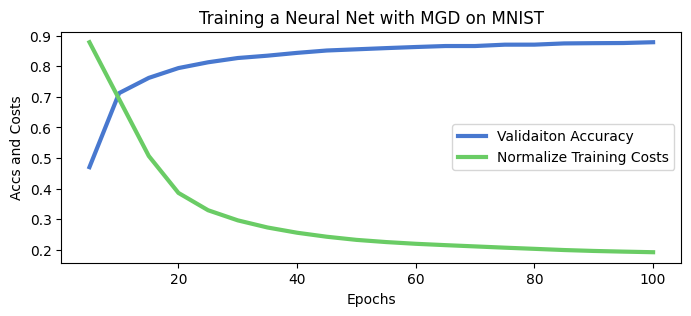

In [13]:
# hyperparams
epochs         = 100
epsilon        = 1e-6
layer_dims     = [128,64,10]
learning_rate  = 1e2
decay          = 0.1
batch_size     = tau_theta = 128
validation_mod = 5
    
# prepare data
batch_size = 128
trainloader, testloader = dat.load_mnist_in_memory(batch_size)
x_batch , y_batch = next(trainloader)

# initializing network
model    = MLP(hidden_sizes=layer_dims)
key      = jax.random.PRNGKey(0)
theta    = model.init(key, x_batch)['params']
apply_fn = model.apply

# normalizing eta and weighting with learning rate
num_params = jnp.size(jax.flatten_util.ravel_pytree(theta)[0])
eta0       = simple_eta_norm(num_params,epsilon) * learning_rate

# corresponding batch size to iterations per epoch / test
batches      = trainloader.X.shape[0]//batch_size
test_batches = testloader.X.shape[0]//batch_size
iterations   = epochs * batches

# for recording training data
costs    = []
accs     = []
valpochs = []
epoch    = 0
epoch_costs      = []
for i in range(iterations):

    # setup for epoch
    x_batch, y_batch = next(trainloader)    # next batch of data
    eta              = eta0/(1+decay*epoch) # decaying learning rate
    gradient         = init_grad(theta)     # all-zero gradient for later accumulation

    # Step 1: Forward pass
    cost0  = loss_fn(apply_fn, theta, x_batch, y_batch)
    epoch_costs.append(cost0)
    
    # Step 2: Perturb
    perturbations   = sample_perturbations(theta,epsilon,i)
    theta_perturbed = apply_perturbations(theta,perturbations)

    # Step 3: Perturbed forward pass
    cost_perturbed   = loss_fn(apply_fn, theta_perturbed, x_batch, y_batch)

    # Step 4: Collect gradient
    delta_cost = (cost_perturbed - cost0)*-1
    gradient   = collect_grad(perturbations, delta_cost, eta, gradient)

    # Step 5: Make update
    theta = optax.apply_updates(theta, gradient)

    # validate (test) only with specified frequency according to validation mod
    if i % batches == 0: epoch+=1
    if i % batches == 0 and epoch % validation_mod == 0:
        
        # testing prediction accuracy over all batches in test set
        batch_accs = [compute_accuracy(apply_fn, theta, *next(testloader)) for _ in range(test_batches)]

        # recording data
        accs.append(np.mean(batch_accs))
        valpochs.append(epoch)
        costs.append(np.mean(epoch_costs))
        epoch_costs = []

        # updating user
        print(f"Iter {i} :: Epoch {epoch}  ::  cost {costs[-1]:.6}  :: accuracy {accs[-1]:.3}     ", 
              end='\r')

# plot the results! (note much higher accuracy can be achieved, but this net is designed for fast runtime)
plt.style.use('seaborn-v0_8-muted')
plt.figure(figsize=(8,3))
plt.plot(valpochs, accs, linewidth=3, label='Validaiton Accuracy')
plt.plot(valpochs, (costs/np.max(costs))*np.max(accs), linewidth=3, label='Normalize Training Costs')
plt.xlabel("Epochs")
plt.ylabel("Accs and Costs")
plt.title("Training a Neural Net with MGD on MNIST")
plt.legend()
plt.show()